# Linear Optimization

Optimizes a linear straight-line path from a point on the viable brain surface region to a point on the subthalamic nucleus (STN) for DBS electrode planning.

Treats the following as obstacles:
- Sulci
- Ventricles
- Corpus Callosum (prevent brain crossing)

**Objective Functions**
- Distance to obstacles
- Minimum path distance  *(not optimized yet)*

## Setup

### Import Libraries

In [14]:
import os
import glob
import random
import numpy as np

import vedo
from vedo import Volume, show, Line, merge, Plotter

### Configuration and Setup

In [2]:
# Define paths and folder names
base_dir = "./FINAL_BRAIN_ATLAS/nii_exports"
brainmask_folder_name = "BRAIN_MASK"
corpus_callosum_folder_name = "CORPUS_CALLLOSUM"
stn_folder_name = "SUBTHALAMIC_NUCLEUS"
sulci_folder_name = "SULCI"
ventricles_folder_name = "VENTRICLES"

obstacle_names = [corpus_callosum_folder_name,
                  sulci_folder_name,
                  ventricles_folder_name]

stn_dir = os.path.join(base_dir, stn_folder_name)

### Load Brain Structures

Load NIfTI files for:
- Brain mask (grey surface)
- Obstacles (corpus callosum, sulci, ventricles in red)
- STN target (green)

In [3]:
# Initialize lists for different structure types
stn_structures = []
obstacle_structures = []
brain_mask_structures = []

for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue

    nii_files = glob.glob(os.path.join(folder_path, "*.nii")) + \
                glob.glob(os.path.join(folder_path, "*.nii.gz"))

    if not nii_files:
        continue

    # Brain mask
    if folder_name == brainmask_folder_name:
        for fpath in nii_files:
            fname = os.path.basename(fpath)
            print(f"  Loading structure: {fname}")
            vol = Volume(fpath)
            surf = vol.isosurface()
            surf.c("grey").alpha(0.01)
            brain_mask_structures.append(surf)
    
    # Obstacles
    elif folder_name in obstacle_names:
        for fpath in nii_files:
            fname = os.path.basename(fpath)
            print(f"  Loading structure: {fname}")
            vol = Volume(fpath)
            surf = vol.isosurface()
            surf.c("red").alpha(0.66)
            obstacle_structures.append(surf)
    # STN
    elif folder_name == stn_folder_name:
        for fpath in nii_files:
            fname = os.path.basename(fpath)
            print(f"  Loading structure: {fname}")
            vol = Volume(fpath)
            surf = vol.isosurface()
            surf.c("green").alpha(1.0)
            stn_structures.append(surf)

  Loading structure: Model_1000_left_insula.nii
  Loading structure: Model_1001_left_superior_temporal_gyrus_(banks_of_left_superior_temporal_sulcus).nii
  Loading structure: Model_1002_caudal_part_of_left_anterior_cingulate_gyrus.nii
  Loading structure: Model_1003_posterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: Model_1005_left_cuneus.nii
  Loading structure: Model_1006_left_ambiens_gyrus.nii
  Loading structure: Model_1007_left_fusiform_gyrus.nii
  Loading structure: Model_1008_left_inferior_parietal_lobule.nii
  Loading structure: Model_1009_left_inferior_temporal_gyrus.nii
  Loading structure: Model_1010_isthmus_of_left_cingulate_gyrus.nii
  Loading structure: Model_1011_left_lateral_occipital_gyrus.nii
  Loading structure: Model_1012_left_lateral_orbital_gyrus.nii
  Loading structure: Model_1013_left_lingual_gyrus.nii
  Loading structure: Model_1014_left_straight_gyrus.nii
  Loading structure: Model_1015_left_middle_temporal_gyrus.nii
  Loading structure: Mode

### Merge Structures

Combine individual structures into single meshes for:
- Brain mask (for sampling start points)
- Obstacles (for intersection detection)
- STN (for sampling target points)

In [4]:
# Merge brain mask structures to define bounding box
merged_brain_mask = None
if brain_mask_structures:
    print("Merging brain mask structures...")
    merged_brain_mask = merge(brain_mask_structures)
    merged_brain_mask.c("grey").alpha(0.01)

# Merge obstacle structures for distance calculations
merged_obstacles = None
if obstacle_structures:
    print("Merging obstacle structures...")
    merged_obstacles = merge(obstacle_structures)
    merged_obstacles.c("red").alpha(0.75)

# Merge STN structures to sample target point
merged_stn = None
if stn_structures:
    print("Merging STN structures...")
    merged_stn = merge(stn_structures)
    merged_stn.c("green").alpha(1.0)

Merging brain mask structures...
Merging obstacle structures...
Merging STN structures...


## Uniform Random Optimization

### Path Generation and Optimization

Generate random paths from brain surface to STN and evaluate them:
- **Purple lines**: Failed paths (intersect obstacles)
- **Yellow lines**: Successful but suboptimal paths
- **Green line**: Optimal path (maximum distance from obstacles)

**Optimization Algorithm**

Runs until finding a successful path and after a minimum of `min_attempts`.

Chooses a **random location** from the viable brain surface region and the STN of the corresponding hemisphere. 

For each plot, the distance from obstacles is saved. The "best" path is determined using the highest distance to obstacles.

In [24]:
# Configuration for path generation
max_attempts = 1000
min_attempts = 10
successful_attempts = []  # Store (start_point, end_point, distance) tuples
failed_lines = []

# Line width configuration (for visualization)
BEST_PATH_WIDTH = 8
SUBOPTIMAL_PATH_WIDTH = 5
FAILED_PATH_WIDTH = 5

In [26]:
# Generate and evaluate paths
for attempt in range(max_attempts):
    if attempt + 1 > min_attempts:
        break
    
    # Select random start (brain surface)
    random_point = merged_brain_mask.generate_random_points(1)
    start_point = tuple(random_point.points[0])
    print(f"Selected start point within brain mask: {start_point}")
    
    # Select random end (STN surface)
    random_point = merged_stn.generate_random_points(1)
    end_point = tuple(random_point.points[0])
    print(f"Selected end point within STN: {end_point}")
    
    # Check for intersection if we have obstacles
    if merged_obstacles:
        intersections = merged_obstacles.intersect_with_line(start_point, end_point)
        
        # If no intersections (empty array or None), line is valid
        if intersections is None or len(intersections) == 0:
            # Compute distance to obstacles
            temp_line = Line([start_point, end_point])
            d = temp_line.distance_to(merged_obstacles)
            if isinstance(d, (list, tuple, np.ndarray)):
                dval = float(np.min(d))
            else:
                dval = float(d)
            
            successful_attempts.append((start_point, end_point, dval))
            print(f"Attempt {attempt+1}: SUCCESS - Distance: {dval:.3f}")
        else:
            # Store failed attempt as purple line
            failed_line = Line([start_point, end_point]).c("purple").alpha(0.3).lw(FAILED_PATH_WIDTH)
            failed_lines.append(failed_line)
            print(f"Attempt {attempt+1}: FAIL - Line intersects obstacles")
    else:
        # No obstacles, accept any line
        temp_line = Line([start_point, end_point])
        successful_attempts.append((start_point, end_point, 0.0))
        print(f"Attempt {attempt+1}: SUCCESS (no obstacles)")
else:
    print(f"Warning: Only found {len(successful_attempts)} non-intersecting lines after {max_attempts} attempts")

Selected start point within brain mask: (np.float32(141.37366), np.float32(92.11965), np.float32(136.7567))
Selected end point within STN: (np.float32(106.561325), np.float32(130.95473), np.float32(72.188675))
Attempt 1: FAIL - Line intersects obstacles
Selected start point within brain mask: (np.float32(39.795025), np.float32(104.79503), np.float32(114.98223))
Selected end point within STN: (np.float32(106.75), np.float32(131.57614), np.float32(71.751114))
Attempt 2: SUCCESS - Distance: 4.345
Selected start point within brain mask: (np.float32(130.51158), np.float32(91.85636), np.float32(82.01157))
Selected end point within STN: (np.float32(107.24318), np.float32(131.34148), np.float32(82.0))
Attempt 3: FAIL - Line intersects obstacles
Selected start point within brain mask: (np.float32(163.89706), np.float32(111.5), np.float32(87.57627))
Selected end point within STN: (np.float32(107.325035), np.float32(133.22813), np.float32(83.34691))
Attempt 4: SUCCESS - Distance: 6.350
Selected s

### Select Optimal Path

Find the best path among successful attempts by maximizing distance from obstacles.

In [27]:
# Find the best path (maximum distance from obstacles)
best_path = None
suboptimal_lines = []

if successful_attempts:
    # Sort by distance (descending)
    successful_attempts.sort(key=lambda x: x[2], reverse=True)
    
    # Best path
    best_start, best_end, best_dist = successful_attempts[0]
    best_path = Line([best_start, best_end]).c("green").lw(BEST_PATH_WIDTH)
    print(f"\nBest path: distance from obstacles {best_dist:.3f}")
    
    # All other successful paths as yellow
    for start_pt, end_pt, dist in successful_attempts[1:]:
        suboptimal_line = Line([start_pt, end_pt]).c("yellow").alpha(0.3).lw(SUBOPTIMAL_PATH_WIDTH)
        suboptimal_lines.append(suboptimal_line)
        print(f"Suboptimal path: distance from obstacles {dist:.3f}")
else:
    print("No successful paths found!")


Best path: distance from obstacles 6.350
Suboptimal path: distance from obstacles 6.016
Suboptimal path: distance from obstacles 5.551
Suboptimal path: distance from obstacles 4.345


## Visualization

Display the brain structures with all generated paths.

### Vedo

Rendering scene with 6 failed attempts, 3 suboptimal paths, and 1 optimal path...


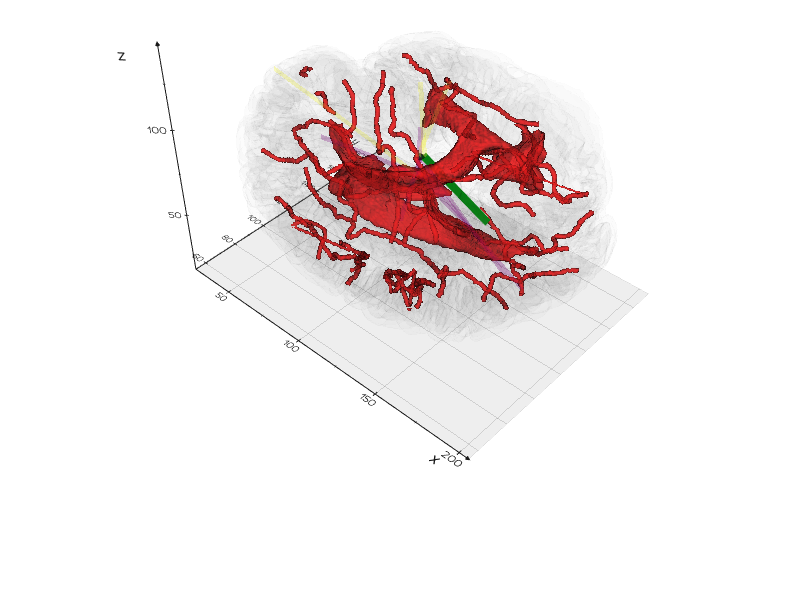

In [28]:
# Prepare actors for visualization
actors = []
actors.extend(brain_mask_structures)
if merged_obstacles:
    actors.append(merged_obstacles)
if merged_stn:
    actors.append(merged_stn)
# Add all failed attempts (intersecting paths)
actors.extend(failed_lines)
# Add suboptimal successful paths
actors.extend(suboptimal_lines)
# Add best path on top
if best_path:
    actors.append(best_path)

print(f"Rendering scene with {len(failed_lines)} failed attempts, {len(suboptimal_lines)} suboptimal paths, and 1 optimal path...")
show(actors, axes=1, viewup="z", title="Optimal Path To STN with Obstacle Distance")

### K3D

In [33]:
# Helper function to convert vedo mesh to k3d mesh
def vedo_to_k3d_mesh(vedo_mesh, color=None, opacity=1.0):
    """Convert a vedo mesh to k3d mesh format."""
    vertices = np.array(vedo_mesh.vertices, dtype=np.float32)
    faces = np.array(vedo_mesh.cells, dtype=np.uint32)
    
    # Get color from vedo mesh if not provided
    if color is None:
        vedo_color = vedo_mesh.color()
        if isinstance(vedo_color, str):
            # Convert color name to hex
            import matplotlib.colors as mcolors
            if vedo_color in mcolors.CSS4_COLORS:
                color_hex = mcolors.CSS4_COLORS[vedo_color]
                color = int(color_hex.lstrip('#'), 16)
            else:
                color = 0x808080  # default grey
        elif isinstance(vedo_color, (list, tuple)):
            # RGB to hex
            r, g, b = [int(c * 255) for c in vedo_color[:3]]
            color = (r << 16) | (g << 8) | b
        else:
            color = 0x808080
    
    # Get opacity from vedo mesh
    vedo_alpha = vedo_mesh.alpha()
    if vedo_alpha is not None:
        opacity = vedo_alpha
    
    return k3d.mesh(vertices, faces, color=color, opacity=opacity)

def vedo_line_to_k3d(vedo_line, color=None, width=0.1):
    """Convert a vedo Line to k3d line format."""
    line_scale_factor = 0.2
    points = np.array(vedo_line.vertices, dtype=np.float32)
    
    # Get color from vedo line if not provided
    if color is None:
        vedo_color = vedo_line.color()
        if isinstance(vedo_color, str):
            import matplotlib.colors as mcolors
            if vedo_color in mcolors.CSS4_COLORS:
                color_hex = mcolors.CSS4_COLORS[vedo_color]
                color = int(color_hex.lstrip('#'), 16)
            else:
                color = 0x00FF00  # default green
        elif isinstance(vedo_color, (list, tuple)):
            r, g, b = [int(c * 255) for c in vedo_color[:3]]
            color = (r << 16) | (g << 8) | b
        else:
            color = 0x00FF00
    
    return k3d.line(points, color=color, width=width*line_scale_factor)

In [34]:
import k3d

# Create k3d plot
plot = k3d.plot(name='Optimal Path To STN with Obstacle Distance')

# Prepare actors for visualization
print(f"Converting {len(brain_mask_structures)} brain mask structures...")
for mesh in brain_mask_structures:
    plot += vedo_to_k3d_mesh(mesh, color=0x808080, opacity=0.01)

if merged_obstacles:
    print("Adding merged obstacles...")
    plot += vedo_to_k3d_mesh(merged_obstacles, color=0xFF0000, opacity=0.75)

if merged_stn:
    print("Adding merged STN...")
    plot += vedo_to_k3d_mesh(merged_stn, color=0x00FF00, opacity=1.0)

# Add all failed attempts (intersecting paths)
print(f"Adding {len(failed_lines)} failed attempts...")
for line in failed_lines:
    plot += vedo_line_to_k3d(line, color=0x800080, width=FAILED_PATH_WIDTH)  # purple

# Add suboptimal successful paths
print(f"Adding {len(suboptimal_lines)} suboptimal paths...")
for line in suboptimal_lines:
    plot += vedo_line_to_k3d(line, color=0xFFFF00, width=SUBOPTIMAL_PATH_WIDTH)  # yellow

# Add best path on top
if best_path:
    print("Adding best path...")
    plot += vedo_line_to_k3d(best_path, color=0x00FF00, width=BEST_PATH_WIDTH)  # green, thicker

print(f"Rendering scene with {len(failed_lines)} failed attempts, {len(suboptimal_lines)} suboptimal paths, and 1 optimal path...")
plot.display()

Converting 91 brain mask structures...
Adding merged obstacles...
Adding merged STN...
Adding 6 failed attempts...
Adding 3 suboptimal paths...
Adding best path...
Rendering scene with 6 failed attempts, 3 suboptimal paths, and 1 optimal path...


Output()